# SVM, KNN, and RFC Image Classification¶

## Libraries Import 

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import load_img
from collections import defaultdict

## Data Preparation

In [2]:
# define paths to train, validation, and test folders
train_dir = "./resize/resize_train"
test_dir = "./resize/resize_test"

# Define dictionary of classes
classes = {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}
label_dict = {'0': 'COVID19', '1': 'NORMAL', '2': 'PNEUMONIA', '3': 'TURBERCULOSIS'}

# Define Empty list for train,test and val dataset and labels.
train_data = []
train_labels = []
test_data = []
test_labels = []

# Default dict used to keep track of the count of each label in order to make the training set balanced
count = defaultdict(int)

# Load training data
for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)
    for img_path in glob.glob(os.path.join(folder_path, "*.*g")):
        label = classes[folder_name.upper()]
        if count[label] > 450:
            continue
        count[label] += 1
        img = load_img(img_path, target_size=(400, 400))
        img_array = np.array(img)
        train_data.append(img_array)
        train_labels.append(label)
        


# Load test data
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)
    for img_path in glob.glob(os.path.join(folder_path, "*.*g")):
        img = load_img(img_path, target_size=(400, 400))
        img_array = np.array(img)
        test_data.append(img_array)
        label = classes[folder_name.upper()]
        test_labels.append(label)

# Convert to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Tranform data into Numpy Array and reshape to 2D
raw_train_data = np.array(train_data).reshape(len(train_data), -1)
train_labels = np.array(train_labels)
raw_test_data = np.array(test_data).reshape(len(test_data), -1)
test_labels = np.array(test_labels)

#### We take only 450 data samples from each label so that the training set is balanced for each label.

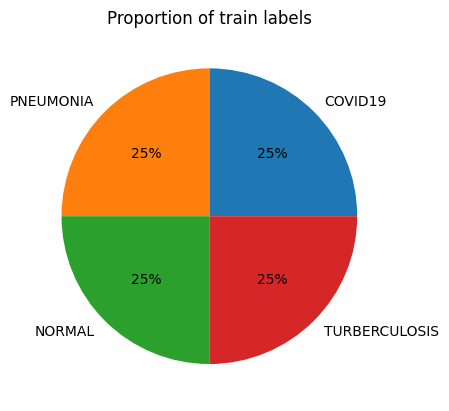

In [23]:
pd.Series(train_labels).apply(lambda x: label_dict[str(x)]).value_counts().plot(kind='pie', autopct="%0.0f%%", title = 'Proportion of train labels');

In [4]:
# Fit a PCA transformation on both training and testing set
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standard_images = scaler.fit_transform(raw_train_data)
pca = PCA(n_components=50, whiten=True, svd_solver='auto')
pca.fit(standard_images)
train_data = pca.transform(raw_train_data)
test_data = pca.transform(raw_test_data)

In [8]:
import pickle
pickle.dump({'pca':pca,'train_data':train_data, 'test_data': test_data}, open('./pca.pickle','wb'))
# Store the pca model, train and test data.

## Display Shapes

In [6]:
# The raw data shape
raw_train_data.shape, train_labels.shape

((1804, 480000), (1804,))

In [7]:
# Shape of the data processed by PCA
test_data.shape, test_labels.shape

((771, 50), (771,))

## SVM Model Training and Testing

In [21]:
# Train and tune the SVM model
svc = SVC(probability=True)
param_grid = {'C':[0.5,1,10,20,30,50],
             'kernel':['rbf'],
             'gamma':[0.1,0.05,0.01,0.001,0.002,0.005],
             'coef0':[0,1]}
model_grid = GridSearchCV(svc,
                          param_grid=param_grid,
                          scoring='recall_macro',cv=3,verbose=2)
# Fit the PCA-transformed data               
model_grid.fit(train_data, train_labels)


# Use the best SVM model
svc = model_grid.best_estimator_
print("Best recall:", model_grid.best_score_)
print("Best parameters:", model_grid.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=   0.8s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=   0.8s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=   0.8s
[CV] END .............C=0.5, coef0=0, gamma=0.01, kernel=rbf; total time=   0.8s
[CV] END .............C=0.5, coef0=0, gamma=0.01, kernel=rbf; total time=   0.8s
[CV] END .............C=0.5, coef0=0, gamma=0.01, kernel=rbf; total time=   0.8s
[CV] END ............C=0.5, coef0=0, gamma=0.001, kernel=rbf; total time=   1.0s
[CV] END ............C=0.5, coef0=0, gamma=0.001, kernel=rbf; total time=   1.1s
[CV] END ............C=0.5, coef0=0, gamma=0.00

From the Result above, we can find the fact that both the validation and test accuracies are 1.0 (i.e., 100%) means that the KNN classifier is able to perfectly classify the images in these datasets. This is a good result, but it may also indicate that the datasets are relatively easy to classify, which may not always be the case in real-world scenarios.
We are going to have further analysis of the classification results, such as examining the confusion matrix to see which classes are being misclassified and why. 

==================== SVM classification report ====================


/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

,precision,recall,f1-score,support
COVID19,1.000000,0.009434,0.018692,106.00000
NORMAL,0.732240,0.572650,0.642686,234.00000
PNEUMONIA,0.614991,0.925641,0.738997,390.00000
TURBERCULOSIS,0.000000,0.000000,0.000000,41.00000
accuracy,0.643320,0.643320,0.643320,0.64332
macro avg,0.586808,0.376931,0.350094,771.00000
weighted avg,0.670805,0.643320,0.571438,771.00000


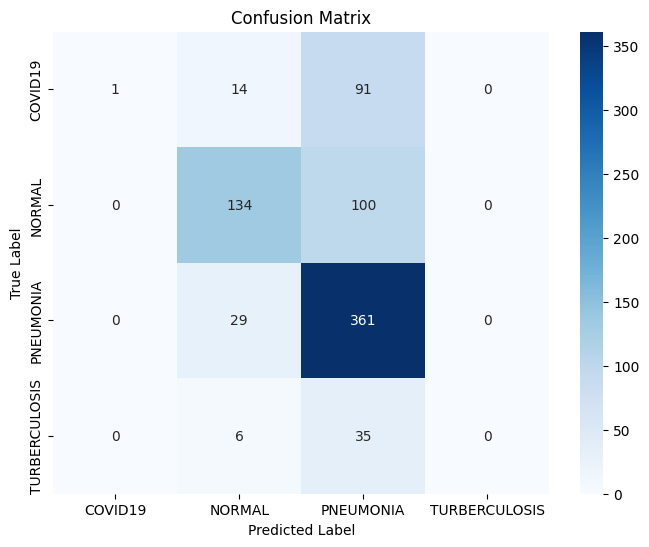

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Display precision, f1 score, recall, and accuracy performance of this model.
print('='*20 + " SVM classification report "+'='*20)
classification_report_svc = metrics.classification_report(test_labels, svc.predict(test_data),output_dict=True)
df = pd.DataFrame(classification_report_svc).T
df.index = pd.Series(df.index).replace(label_dict)
display(df)

# Predict the labels of the test data using the trained SVM classifier
test_preds = svc.predict(test_data)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes.keys(), yticklabels=classes.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Since the rulst showing is pretty high, it is useful to try different machine learning models or tuning the hyperparameters of the KNN classifier to see if better performance can be achieved. Trying different models will be shown in other section, we will focus on tuning the hyperparameters of the KNN classifier to determine if it can achieve improved performance. 
To tune the hyperparameters of the KNN classifier, we used a grid search approach. This involves trying out different values for the hyperparameters and selecting the combination that gives the best performance on the validation set.

## KNN model trainig and testing

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = {'n_neighbors':[1,5,10,20,30,40],
             'leaf_size':[20, 30, 40]}
model_grid = GridSearchCV(knn,
                          param_grid=param_grid,
                          scoring='recall_macro',cv=3,verbose=2)
model_grid.fit(train_data, train_labels)

# Use the best knn model
knn = model_grid.best_estimator_
print("Best recall:", model_grid.best_score_)
print("Best parameters:", model_grid.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ........................leaf_size=20, n_neighbors=1; total time=   0.0s
[CV] END ........................leaf_size=20, n_neighbors=1; total time=   0.0s
[CV] END ........................leaf_size=20, n_neighbors=1; total time=   0.0s
[CV] END ........................leaf_size=20, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=20, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=20, n_neighbors=5; total time=   0.0s
[CV] END .......................leaf_size=20, n_neighbors=10; total time=   0.0s
[CV] END .......................leaf_size=20, n_neighbors=10; total time=   0.0s
[CV] END .......................leaf_size=20, n_neighbors=10; total time=   0.0s
[CV] END .......................leaf_size=20, n_neighbors=20; total time=   0.0s
[CV] END .......................leaf_size=20, n_neighbors=20; total time=   0.0s
[CV] END .......................leaf_size=20, n_

==================== KNN classification report ====================


,precision,recall,f1-score,support
COVID19,0.747899,0.839623,0.791111,106.000000
NORMAL,0.770833,0.474359,0.587302,234.000000
PNEUMONIA,0.773218,0.917949,0.839390,390.000000
TURBERCULOSIS,0.666667,0.731707,0.697674,41.000000
accuracy,0.762646,0.762646,0.762646,0.762646
macro avg,0.739654,0.740909,0.728869,771.000000
weighted avg,0.763347,0.762646,0.748707,771.000000


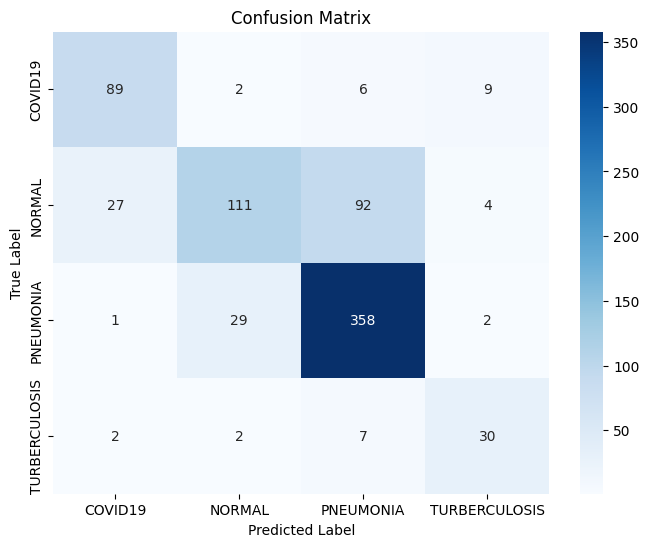

In [17]:
# Display precision, f1 score, recall, and accuracy performance of this model.
print('='*20 + " KNN classification report "+'='*20)
classification_report_knn = metrics.classification_report(test_labels, knn.predict(test_data),output_dict=True)
df = pd.DataFrame(classification_report_knn).T
df.index = pd.Series(df.index).replace(label_dict)
display(df)

# Predict the labels of the test data using the trained SVM classifier
test_preds = knn.predict(test_data)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes.keys(), yticklabels=classes.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Random Forest Classifier model trainig and testing

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
param_grid = {'max_depth':[2, 4, 6, 8, 10, 12], 'n_estimators': [5, 10, 20, 50, 100]}
model_grid = GridSearchCV(rfc,
                          param_grid=param_grid,
                          scoring='recall_macro',cv=3,verbose=2)
model_grid.fit(train_data, train_labels)

# Use the best rfc model
rfc = model_grid.best_estimator_
print("Best recall:", model_grid.best_score_)
print("Best parameters:", model_grid.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=2, n_e

==================== RFC classification report ====================


,precision,recall,f1-score,support
COVID19,0.848214,0.896226,0.871560,106.000000
NORMAL,0.862903,0.457265,0.597765,234.000000
PNEUMONIA,0.804878,0.930769,0.863258,390.000000
TURBERCULOSIS,0.464286,0.951220,0.624000,41.000000
accuracy,0.783398,0.783398,0.783398,0.783398
macro avg,0.745070,0.808870,0.739146,771.000000
weighted avg,0.810335,0.783398,0.771099,771.000000


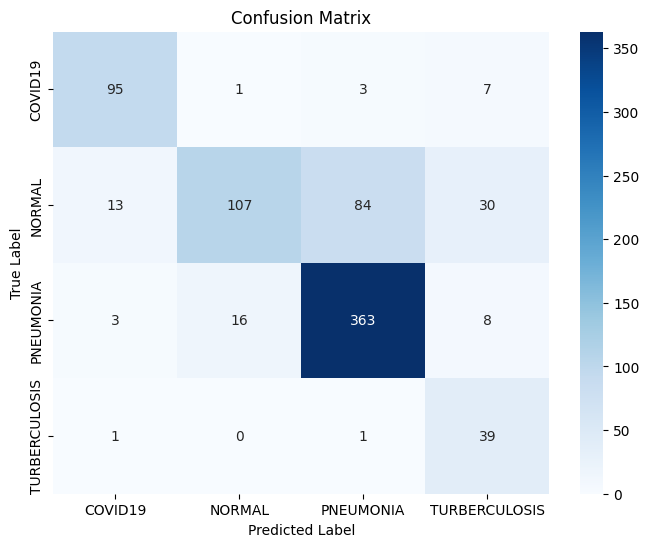

In [20]:
# Display precision, f1 score, recall, and accuracy performance of this model.
print('='*20 + " RFC classification report "+'='*20)
classification_report_rfc = metrics.classification_report(test_labels, rfc.predict(test_data),output_dict=True)
df = pd.DataFrame(classification_report_rfc).T
df.index = pd.Series(df.index).replace(label_dict)
display(df)

# Predict the labels of the test data using the trained SVM classifier
test_preds = rfc.predict(test_data)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes.keys(), yticklabels=classes.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()